<a href="https://colab.research.google.com/github/decoderkurt/HUF_RL_2022/blob/main/27/simple_sac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir SAC

In [2]:
!pip install box2d-py
!pip install gym[Box_2D]
!pip install pybullet

     |████████████████████████████████| 448 kB 7.6 MB/s 
     |████████████████████████████████| 90.8 MB 1.1 MB/s 


In [3]:
import numpy as np

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones



In [4]:
import os
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import numpy as np

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, n_actions, fc1_dims=256, fc2_dims=256,
            name='critic', chkpt_dir='SAC'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')

        self.fc1 = nn.Linear(self.input_dims[0]+n_actions, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state, action):
        action_value = self.fc1(T.cat([state, action], dim=1))
        action_value = F.relu(action_value)
        action_value = self.fc2(action_value)
        action_value = F.relu(action_value)

        q = self.q(action_value)

        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class ValueNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims=256, fc2_dims=256,
            name='value', chkpt_dir='SAC'):
        super(ValueNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, fc2_dims)
        self.v = nn.Linear(self.fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        state_value = self.fc1(state)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = F.relu(state_value)

        v = self.v(state_value)

        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, max_action, fc1_dims=256, 
            fc2_dims=256, n_actions=2, name='actor', chkpt_dir='SAC'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_sac')
        self.max_action = max_action
        self.reparam_noise = 1e-6

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        self.sigma = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)

    def forward(self, state):
        prob = self.fc1(state)
        prob = F.relu(prob)
        prob = self.fc2(prob)
        prob = F.relu(prob)

        mu = self.mu(prob)
        sigma = self.sigma(prob)

        sigma = T.clamp(sigma, min=self.reparam_noise, max=1)

        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        probabilities = Normal(mu, sigma)

        if reparameterize:
            actions = probabilities.rsample()
        else:
            actions = probabilities.sample()

        action = T.tanh(actions)*T.tensor(self.max_action).to(self.device)
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1-action.pow(2)+self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))


In [5]:
import os
import torch as T
import torch.nn.functional as F
import numpy as np

class Agent():
    def __init__(self, alpha=0.0003, beta=0.0003, input_dims=[8],
            env=None, gamma=0.99, n_actions=2, max_size=1000000, tau=0.005,
            layer1_size=256, layer2_size=256, batch_size=256, reward_scale=2):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.actor = ActorNetwork(alpha, input_dims, n_actions=n_actions,
                    name='actor', max_action=env.action_space.high)
        self.critic_1 = CriticNetwork(beta, input_dims, n_actions=n_actions,
                    name='critic_1')
        self.critic_2 = CriticNetwork(beta, input_dims, n_actions=n_actions,
                    name='critic_2')
        self.value = ValueNetwork(beta, input_dims, name='value')
        self.target_value = ValueNetwork(beta, input_dims, name='target_value')

        self.scale = reward_scale
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = T.Tensor([observation]).to(self.actor.device)
        actions, _ = self.actor.sample_normal(state, reparameterize=False)

        return actions.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_value_params = self.target_value.named_parameters()
        value_params = self.value.named_parameters()

        target_value_state_dict = dict(target_value_params)
        value_state_dict = dict(value_params)

        for name in value_state_dict:
            value_state_dict[name] = tau*value_state_dict[name].clone() + \
                    (1-tau)*target_value_state_dict[name].clone()

        self.target_value.load_state_dict(value_state_dict)

    def save_models(self):
        print('.... saving models ....')
        self.actor.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()

    def load_models(self):
        print('.... loading models ....')
        self.actor.load_checkpoint()
        self.value.load_checkpoint()
        self.target_value.load_checkpoint()
        self.critic_1.load_checkpoint()
        self.critic_2.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        state, action, reward, new_state, done = \
                self.memory.sample_buffer(self.batch_size)

        reward = T.tensor(reward, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)
        state_ = T.tensor(new_state, dtype=T.float).to(self.actor.device)
        state = T.tensor(state, dtype=T.float).to(self.actor.device)
        action = T.tensor(action, dtype=T.float).to(self.actor.device)

        value = self.value(state).view(-1)
        value_ = self.target_value(state_).view(-1)
        value_[done] = 0.0

        actions, log_probs = self.actor.sample_normal(state, reparameterize=False)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(state, actions)
        q2_new_policy = self.critic_2.forward(state, actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)

        self.value.optimizer.zero_grad()
        value_target = critic_value - log_probs
        value_loss = 0.5 * F.mse_loss(value, value_target)
        value_loss.backward(retain_graph=True)
        self.value.optimizer.step()

        actions, log_probs = self.actor.sample_normal(state, reparameterize=True)
        log_probs = log_probs.view(-1)
        q1_new_policy = self.critic_1.forward(state, actions)
        q2_new_policy = self.critic_2.forward(state, actions)
        critic_value = T.min(q1_new_policy, q2_new_policy)
        critic_value = critic_value.view(-1)
        
        actor_loss = log_probs - critic_value
        actor_loss = T.mean(actor_loss)
        self.actor.optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        self.actor.optimizer.step()

        self.critic_1.optimizer.zero_grad()
        self.critic_2.optimizer.zero_grad()
        q_hat = self.scale*reward + self.gamma*value_
        q1_old_policy = self.critic_1.forward(state, action).view(-1)
        q2_old_policy = self.critic_2.forward(state, action).view(-1)
        critic_1_loss = 0.5 * F.mse_loss(q1_old_policy, q_hat)
        critic_2_loss = 0.5 * F.mse_loss(q2_old_policy, q_hat)

        critic_loss = critic_1_loss + critic_2_loss
        critic_loss.backward()
        self.critic_1.optimizer.step()
        self.critic_2.optimizer.step()

        self.update_network_parameters()


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

.... saving models ....
episode  0 score 15.0 avg_score 15.0
.... saving models ....
episode  1 score 21.0 avg_score 18.0
.... saving models ....
episode  2 score 24.0 avg_score 20.0
.... saving models ....
episode  3 score 52.0 avg_score 28.0
.... saving models ....
episode  4 score 40.0 avg_score 30.4
episode  5 score 22.0 avg_score 29.0
episode  6 score 14.0 avg_score 26.9
episode  7 score 16.0 avg_score 25.5
episode  8 score 24.0 avg_score 25.3
episode  9 score 47.0 avg_score 27.5
episode  10 score 40.0 avg_score 28.6
episode  11 score 33.0 avg_score 29.0
episode  12 score 20.0 avg_score 28.3
episode  13 score 18.0 avg_score 27.6
episode  14 score 12.0 avg_score 26.5
episode  15 score 18.0 avg_score 26.0
episode  16 score 26.0 avg_score 26.0
episode  17 score 20.0 avg_score 25.7
episode  18 score 50.0 avg_score 26.9
episode  19 score 12.0 avg_score 26.2
episode  20 score 14.0 avg_score 25.6
episode  21 score 16.0 avg_score 25.2
episode  22 score 31.0 avg_score 25.4
episode  23 scor

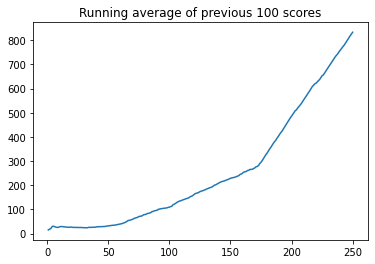

In [8]:
import gym
import numpy as np
import pybullet_envs
from gym import wrappers

env = gym.make('InvertedPendulumBulletEnv-v0')
agent = Agent(input_dims=env.observation_space.shape, env=env,
        n_actions=env.action_space.shape[0])
n_games = 250
# uncomment this line and do a mkdir SAC && mkdir video if you want to
# record video of the agent playing the game.
#env = wrappers.Monitor(env, 'SAC/video', video_callable=lambda episode_id: True, force=True)
filename = 'inverted_pendulum.png'

figure_file = 'SAC/' + filename

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

#if load_checkpoint:
#    agent.load_models()
#    env.render(mode='human')

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.remember(observation, action, reward, observation_, done)
        if not load_checkpoint:
            agent.learn()
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)
